### Train EfficientNet Family for Final Model
Clean up and simplify chapter four code that searched across multiple models.  streamline it down to its component parts and match it up to the winning experiment 5 with EfficientNetB0.  
Took recommendation from chapter four and tried to train that model and save it; save failed.  
Tensorflow forums suggested using V1B1 or V2B0 to fix the problem.  V1 B1 failed to save too and the V2B0 model was terrible.  
Tried V2 B1 and got slightly better results, but not as good as V1 B0/B1.  
Forums also suggested downgrading TF to 2.9.1 to fix the issue.  That worked on the base model.  
Trained EfficientNetB0 (version 1 of EfficientNet) and save that model.  

Pip code below downgrads TF to 2.9.1 from 2.11; 

In [1]:
!pip uninstall -y tensorflow
!pip install tensorflow==2.9.1

Found existing installation: tensorflow 2.9.1
Uninstalling tensorflow-2.9.1:
  Successfully uninstalled tensorflow-2.9.1
  Using cached tensorflow-2.9.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.0 kB)
Using cached tensorflow-2.9.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (511.7 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-serving-api 2.11.0 requires tensorflow<3,>=2.11.0, but you have tensorflow 2.9.1 which is incompatible.


In [2]:
# import the libraries for training, testing, validation
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import imagenet_utils  # will decode predictions out of the model into a 4 dim array of N (image num), imageID, label, probability result[0] would be the set of results for image one
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img  # will load img and reshape, usage is load_img(image_name_loc, target_size=input_shape)
from tensorflow.keras.utils import plot_model  # Note: usage syntax is plot_model(instantied_model, to_file='', show_shapes=True)
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, regularizers
# from tensorflow.keras.layers import RandomShear  # couldn't get random shear to load
from tensorflow.keras.models import Model
import tensorflow_datasets as tfds  # For loading datasets from GCS
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers.experimental import AdamW, Adam


# add capabilities to generate data and stop early as well as regulation options to avoid over fitting per experiment #1
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard

# import all model architectures
from tensorflow.keras.applications import EfficientNetB0, EfficientNetV2B0, EfficientNetV2B1


import matplotlib.pyplot as plt
import numpy as np
import os
import datetime
import time
import math
from sklearn.metrics import classification_report, confusion_matrix

# suppress warnings
from absl import logging  # tensorflow internal log
logging.set_verbosity(logging.ERROR)
tf.get_logger().setLevel(logging.ERROR)


In [3]:
# define a dictionary for model config and experiment tracking.... 
# define global variables
gcs_bucket = 'nabirds_filtered'  
dataset_path = 'images'  # Relative path within the bucket
default_batch_size = 32
default_image_size = (224, 224)
model = None  # use this later to laod from disk if none


In [4]:
def load_images_gcs(bucket_name, dataset_path, model_image_size, model_batch_size, shuffle=True):
    dataset = None
    gcs_dataset_path = f"gs://{bucket_name}/{dataset_path}"
    try:
        dataset = keras.utils.image_dataset_from_directory(gcs_dataset_path, image_size=model_image_size,
            batch_size=model_batch_size, label_mode='categorical', shuffle=shuffle)  # categorical is for softmax layer, shuffle sets randomness for train or valid
    except Exception as e:
        print(f'error loading dataset from gcs: {e}')    
    return dataset

In [5]:
# split into its own cell so we do not have to repeat this long operation, takes 10 minutes....
# need to run this each time for different image and batch sizes
def load_images(image_size=default_image_size, batch_size=default_batch_size):
    start_time = time.time()
    start_time_datetime = datetime.datetime.fromtimestamp(start_time)
    print(f'Start loading images time: {start_time_datetime.strftime("%Y-%m-%d %H:%M:%S")}')
    print(f'Loading with image size of {image_size} and batch size of {batch_size}')

    train_dataset = load_images_gcs(gcs_bucket, os.path.join(dataset_path, 'train'), image_size, batch_size, shuffle=True)
    validate_dataset = load_images_gcs(gcs_bucket, os.path.join(dataset_path, 'test'), image_size, batch_size, shuffle=False)

    if train_dataset is None or validate_dataset is None:
        print(f'dataset loading failed.')
    return train_dataset, validate_dataset

In [6]:
def plot_training_results(acc, validate_acc, loss, validate_loss):
    epochs_plt = range(1, len(acc) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_plt, acc, 'b', label='Training accuracy')
    plt.plot(epochs_plt, validate_acc, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_plt, loss, 'b', label='Training loss')
    plt.plot(epochs_plt, validate_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    return

In [7]:
# lock and unlock layers, make this bullet proof so I don't have to think about the experiments too much
def lock_unlock_layers(model, train_last_x_layers):
    train_last_x_layers = 0 if train_last_x_layers == None else train_last_x_layers
    fine_tune_at = len(model.layers) - abs(train_last_x_layers)                        
    fine_tune_at = 0 if fine_tune_at < 0 else fine_tune_at
    for layer in model.layers[:fine_tune_at]:
        layer.trainable = False
    for layer in model.layers[fine_tune_at:]:
        layer.trainable = True
    return model

In [21]:
@tf.autograph.experimental.do_not_convert
def run_model_experiment_c4(experiment_name, model_name, stages, stage1, stage2, train_dataset, validate_dataset, num_classes, log_record):
    stage1_learning = stage1["learning_rate"]
    stage1_epochs = stage1["epochs"]
    stage1_base_trainable = stage1['base_trainable']
    stage1_trainable_layers = stage1['trainable_layers']
    stage2_learning = stage2["learning_rate"]
    stage2_epochs = stage2["epochs"]
    stage2_base_trainable = stage2['base_trainable']
    stage2_trainable_layers = stage2['trainable_layers']
    
    start_time = time.time()
    start_time_datetime = datetime.datetime.fromtimestamp(start_time)
    print(f'Start time training and validation: {start_time_datetime.strftime("%Y-%m-%d %H:%M:%S")}')
    print(f'building model: {model_name} with {stages} stage(s)')
    print(f'stage1... ')
    print(f'epochs: {stage1_epochs}')
    print(f'learning rate of {stage1_learning}')
    print(f'trainable: {stage1_base_trainable}')
    print(f'trainable_layers: {stage1_trainable_layers}')
    
     # load each mode type and modify head for softmax replacement
    if model_name == 'MobileNetV2':
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) 
    elif model_name == 'MobileNetV3Large':
        base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) 
    elif model_name == 'MobileNetV3Small':
        base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) 
    elif model_name == 'EfficientNetB0':
        base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_name == 'InceptionV3':
        base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(229, 229, 3))
    elif model_name == 'EfficientNetB7':
        base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(600, 600, 3))
    elif model_name == 'EfficientNetB1':
        base_model = EfficientNetB1(weights='imagenet', include_top=False, input_shape=(240, 240, 3))
    elif model_name == 'EfficientNetB2':
        base_model = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(288, 288, 3))
    elif model_name == 'EfficientNetB3':
        base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(300, 300, 3))
    else:
        print(f'unknown model {model_name} inf run_model_experiment case statement')

    ### setup call backs and other admin...
    # save best model, save model when monitored metric improved, 'max' for accuracy, 'min' for loss
    # callbacks early stopping and learning rate reduction
    # suppress warnings
    model_filename = experiment_name + model_name + '.h5'
    # model_checkpoint_callback = ModelCheckpoint(filepath=model_filename, save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)  # added save weights for efficientnet
    # model_checkpoint_callback = ModelCheckpoint(filepath=model_filename, save_best_only=True, monitor='val_accuracy', mode='max', verbose=1, save_weights_only=True)
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0000001)
    tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
    
    #####  setup stage 1 of X #####
    base_model.trainable = stage1_base_trainable  # true unlocks the entire model
    if stage1_base_trainable is False and stage1_trainable_layers != None:  # false a number unlocks the last x layers
        base_model = lock_unlock_layers(model=base_model, train_last_x_layers=stage1_trainable_layers)
    x = base_model.output  # start adding custom layers
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)  
    predictions = Dense(num_classes, activation='softmax')(x)

    # create the model with rescaling layer, this will automatically normalize the images within the model, bulletproofs feeder code
    # normalize pixel values to [0, 1], not sure if this was done in the old mobilenetv2 model
    inputs = base_model.input
    rescaled_inputs = tf.keras.layers.Rescaling(1./255)(inputs)  
    augmentation_layers = Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1), 
    ])
    augmented_inputs = augmentation_layers(rescaled_inputs) 
    x = base_model(augmented_inputs) 
    model = Model(inputs=inputs, outputs=predictions) # use original inputs
    
    # Define TensorBoard callback
    log_dir = os.path.join("logs", experiment_name + "_" + model_name + "_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
        
    # compile and train model, epoch zero is starting place for first stage, categorical crossentropy is for multi-class classification
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=stage1_learning), loss='categorical_crossentropy', 
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    history_phase1 = model.fit(train_dataset, epochs=stage1_epochs, initial_epoch=0, validation_data=validate_dataset, 
                               callbacks=[early_stopping, reduce_lr] )  
                               # callbacks=[model_checkpoint_callback, early_stopping, reduce_lr] )  # removed model checkpoint as it was not working propertly

    ##### setup stage 2 if requested
    combined_history = {}
    print(f'history 1 keys: {history_phase1.history.keys()}')
    if stages == 2:
        print(f'stage2...')
        model = lock_unlock_layers(model=model, train_last_x_layers=stage2_trainable_layers)
        # Recompile the model and continue from phase1, last epoch + 1 to move to next available 
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=stage2_learning), loss='categorical_crossentropy', 
                      metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
        history_phase2 = model.fit(train_dataset, epochs=stage1_epochs + stage2_epochs, initial_epoch=stage1_epochs, validation_data=validate_dataset,
                                  callbacks=[early_stopping, reduce_lr])   
                                  # callbacks=[model_checkpoint_callback, early_stopping, reduce_lr])   
        print(f'history2 keys: {history_phase2.history.keys()}')
        for key in history_phase1.history:  # combine history
            try:
                combined_history[key] = history_phase1.history[key] + history_phase2.history[key]
            except:
                pass
                #     print(f'history1 key {key} not found in history2 ')
        for key2 in history_phase2.history:
            if key2 not in history_phase1.history:
                combined_history[key2] = history_phase2.history[key2]
    else:
        stage2_epochs=0
        combined_history = history_phase1.history  # if one state take stage 1 hist    
                
    #### process results and save model
    # save the entire model (architecture + weights)
    try:
        model.save(model_filename)
        print(f'model saved to: {model_filename}')
    except Exception as e:
        print(f'model save failed with error {e}')
    
    # record training time
    end_time = time.time()
    end_time_datetime = datetime.datetime.fromtimestamp(end_time)
    print(f'End time training and validation: {end_time_datetime.strftime("%Y-%m-%d %H:%M:%S")}')

    # write_results_to_file
    total_epochs = stage1_epochs + stage2_epochs
    acc = combined_history['accuracy']
    validate_acc = combined_history['val_accuracy']
    loss = combined_history['loss']
    validate_loss = combined_history['val_loss']

    plot_training_results(acc, validate_acc, loss, validate_loss) 
    return model, acc, validate_acc, loss, validate_loss

In [9]:
# the experiments dictionary drives the model types and training parameters 
# loop over each model type, stages, and write out results of experiment to a file, save the model
@tf.autograph.experimental.do_not_convert
def run_experiments_c4(experiments, train_dataset, validate_dataset, num_classes, log_record=True):
    for exper in list(experiments.keys()):
        stages = experiments[exper]['number_of_stages']
        stage1 = experiments[exper]['stage1']
        stage2 = experiments[exper]['stage2']
        
        for model_num in experiments[exper]['model_types']:
            model_name = models_list[model_num]
            model, acc, validate_acc, loss, validate_loss = run_model_experiment_c4(exper, model_name, stages, stage1, stage2, 
                                                                          train_dataset, validate_dataset, num_classes, 
                                                                         log_record)
    return model

In [10]:
# define a dictionary for model config and experiment tracking.... 
# define global variables
gcs_bucket = 'nabirds_filtered'  
dataset_path = 'images'  # Relative path within the bucket
default_batch_size = 32
default_image_size = (224, 224)

model_input_variables = {'MobileNetV2': {'input_shape': (224, 224, 3), 'batch_size': 32,},
     'MobileNetV3Large': {'input_shape': (224, 224, 3),'batch_size': 32,},
    'MobileNetV3Small':{'input_shape': (224, 224, 3), 'batch_size': 32,},
    'EfficientNetB0': {'input_shape': (224, 224, 3), 'batch_size': 32,},
    'InceptionV3': {'input_shape': (299, 299, 3), 'batch_size': 32,}, # InceptionV3 typically uses 299x299
    'EfficientNetB7':{'input_shape': (600, 600, 3), 'batch_size': 16,}, # this is a larger model and the norm seems to be smaller batch sizes for reduced memory use
    'EfficientNetB1': {'input_shape': (240, 240, 3), 'batch_size': 32,},  # added 1 thru 6 during experiment 3
    'EfficientNetB2': {'input_shape': (288, 288, 3), 'batch_size': 32,},
    'EfficientNetB3': {'input_shape': (300, 300, 3), 'batch_size': 32,},
    'EfficientNetB4': {'input_shape': (380, 380, 3), 'batch_size': 32,},
    'EfficientNetB5': {'input_shape': (456, 456, 3), 'batch_size': 32,},
    'EfficientNetB6': {'input_shape': (528, 528, 3), 'batch_size': 32,}
}
models_list = list(model_input_variables.keys())

In [11]:
# load the default data do not loop over this code unless its an exception. 
default_train_dataset, default_validate_dataset = load_images()
num_classes = len(default_train_dataset.class_names) # get class count, same no mater how the data is loaded given the same data set

Start loading images time: 2025-04-22 19:09:10
Loading with image size of (224, 224) and batch size of 32
Found 2455 files belonging to 27 classes.
Level 1:tensorflow:Creating new FuncGraph for Python function <function StructuredFunctionWrapper.__init__.<locals>.trace_tf_function.<locals>.wrapped_fn at 0x7f570a90dc60> (key: FunctionCacheKey(function_signature=Tuple(collection_type=<class 'tuple'>, components=(TensorSpec(shape=(), dtype=tf.string, name=None),)), call_context=FunctionContext(context=EagerContext(parent_graph=None, device_functions=(), colocation_stack=(), in_cross_replica_context=False, variable_policy=None, xla_context_id=0))))
Level 2:tensorflow:Python function signature [args: None] [kwargs: None]
Level 1:tensorflow:Creating new FuncGraph for Python function <function StructuredFunctionWrapper.__init__.<locals>.trace_tf_function.<locals>.wrapped_fn at 0x7f570a90d000> (key: FunctionCacheKey(function_signature=Tuple(collection_type=<class 'tuple'>, components=(TensorSp

2025-04-22 19:17:38.839790: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-04-22 19:17:39.140984: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-04-22 19:17:39.141247: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-04-22 19:17:39.143187: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Found 621 files belonging to 27 classes.
Level 1:tensorflow:Creating new FuncGraph for Python function <function StructuredFunctionWrapper.__init__.<locals>.trace_tf_function.<locals>.wrapped_fn at 0x7f570a90e4d0> (key: FunctionCacheKey(function_signature=Tuple(collection_type=<class 'tuple'>, components=(TensorSpec(shape=(), dtype=tf.string, name=None),)), call_context=FunctionContext(context=EagerContext(parent_graph=None, device_functions=(), colocation_stack=(), in_cross_replica_context=False, variable_policy=None, xla_context_id=0))))
Level 2:tensorflow:Python function signature [args: None] [kwargs: None]
Level 1:tensorflow:Creating new FuncGraph for Python function <function StructuredFunctionWrapper.__init__.<locals>.trace_tf_function.<locals>.wrapped_fn at 0x7f570a90f370> (key: FunctionCacheKey(function_signature=Tuple(collection_type=<class 'tuple'>, components=(TensorSpec(shape=(), dtype=tf.int32, name=None),)), call_context=FunctionContext(context=EagerContext(parent_graph=

### EffecientNet HyperParameter Searching


### Chapter 4 V2 Experiments
V1B0 search1; 100 epochs lr of 1e-4, min lr 1e-7, data aug .1, l2 reg .001; 92.0% VA in epoch 32  
V1B0 search2; 50 epochs, 1r of 1e-5, min lr 1e-7, data aug .2 l2 reg .001; early stopping, VA 91.1% in epoch 43,   
V2B0 search1; 50 epochs, lr of 1e-4, min lr NA, data aug .1, l2 reg .001; VA 79.7%, epoch 50 
V2B0 search2; 50 epochs, lr of 1e-5, min lr NA, data aug .2, l2 reg .01; VA 81%, E50  
V2B1 search1; 50 epochs, lr of 1e-5, min lr 1e-7, data aug .1, l2 reg .001; early stopping; adj lr; image size 300x300; VA 85%   
V1b0 search3; corrected model save error; downgraded TF to 2.9.1 from 2.11; VA 89%; why is this lower?  something is different in the code base;  
v1b0 search4; copied code from chap4 exactly and reran the model; TF 2.9.1 VA 91.4% Precision ,l2 reg .001
v1b0 seearc5; l2 reg .01


Start time training and validation: 2025-04-22 01:36:40
building model: EfficientNetB0 with 1 stage(s)
stage1... 
epochs: 100
learning rate of 0.0001
trainable: True
trainable_layers: None
Epoch 1/100
77/77 [==============================] - 64s 649ms/step - loss: 3.8329 - accuracy: 0.3434 - precision_6: 0.9792 - recall_6: 0.0191 - val_loss: 2.2267 - val_accuracy: 0.6699 - val_precision_6: 0.8815 - val_recall_6: 0.4074 - lr: 1.0000e-04
Epoch 2/100
77/77 [==============================] - 48s 585ms/step - loss: 2.0452 - accuracy: 0.8045 - precision_6: 0.9539 - recall_6: 0.5141 - val_loss: 1.5451 - val_accuracy: 0.8728 - val_precision_6: 0.9270 - val_recall_6: 0.8180 - lr: 1.0000e-04
Epoch 3/100
77/77 [==============================] - 47s 563ms/step - loss: 1.4664 - accuracy: 0.9092 - precision_6: 0.9676 - recall_6: 0.8383 - val_loss: 1.4319 - val_accuracy: 0.8953 - val_precision_6: 0.9317 - val_recall_6: 0.8567 - lr: 1.0000e-04
Epoch 4/100
77/77 [==============================] - 50s 6

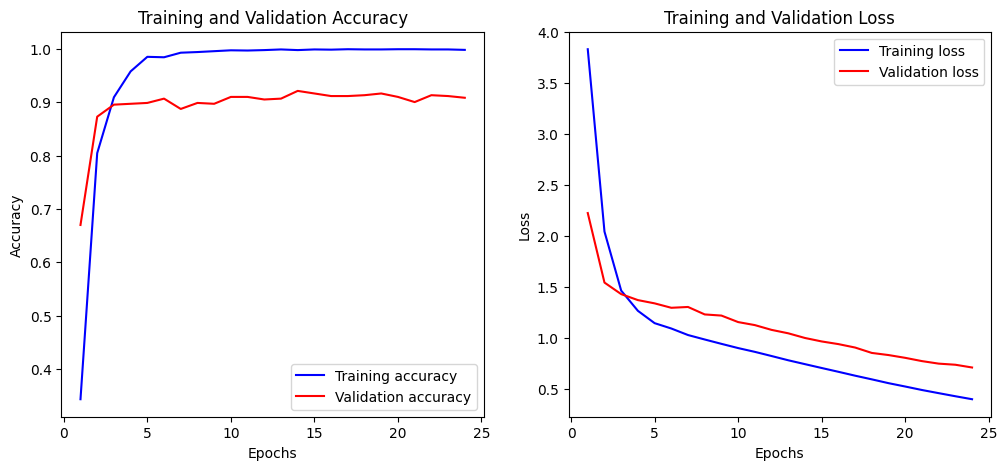

In [50]:
#### Experiment 5 EfficentNetB0 
# train all layers with data augmentation and regularization
models_list = list(model_input_variables.keys())
experiment_dict = {
    'Experiment5:EfficientNetB0': { 
        # 'model_types': [0, 1, 2, 3], # leave out the two models with weird image sizes for now
        'model_types': [3], # EfficientNetB0
        'number_of_stages': 1, 
        'stage1': {'epochs': 100, 'base_trainable': True, 'trainable_layers': None, 'learning_rate': 0.0001},
        'stage2': {'epochs': 1, 'base_trainable': False, 'trainable_layers': None, 'learning_rate': 0.00001}
    }
}

model = run_experiments_c4(experiment_dict, default_train_dataset, default_validate_dataset, num_classes)

In [51]:
# save the model as a full directory and a .h5 file
model_dir_name = 'efficientnetb0_e5'
try:
    model.save(model_dir_name)
    print(f'model saved to directory: {model_dir_name}')
    model.save(model_dir_name + '.h5')
    print(f'model saved to file: {model_dir_name}.h5')
except Exception as e:
    print(f'model save failed with error {e}')

model saved to directory: efficientnetb0_e5
model saved to file: efficientnetb0_e5.h5


In [12]:
# start eval, load model if needed
if model is None:
    model = keras.models.load_model('efficientnetb0_e5')
    print('loaded model from disk')

Level 1:tensorflow:Registering CustomGradient-2016 (<function _gen_gradient_func.<locals>.gradient_func at 0x7f57080b3f40>) in gradient.
Level 1:tensorflow:Registering CustomGradient-2009 (<function _gen_gradient_func.<locals>.gradient_func at 0x7f57080b2320>) in gradient.
Level 1:tensorflow:Registering CustomGradient-1972 (<function _gen_gradient_func.<locals>.gradient_func at 0x7f57080b2200>) in gradient.
Level 1:tensorflow:Registering CustomGradient-2185 (<function _gen_gradient_func.<locals>.gradient_func at 0x7f57080b1ea0>) in gradient.
Level 1:tensorflow:Registering CustomGradient-2150 (<function _gen_gradient_func.<locals>.gradient_func at 0x7f57080b1fc0>) in gradient.
Level 1:tensorflow:Registering CustomGradient-2205 (<function _gen_gradient_func.<locals>.gradient_func at 0x7f57080b1900>) in gradient.
Level 1:tensorflow:Registering CustomGradient-2035 (<function _gen_gradient_func.<locals>.gradient_func at 0x7f57080b1c60>) in gradient.
Level 1:tensorflow:Registering CustomGrad

tf.Tensor(
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.], shape=(27,), dtype=float32)
0


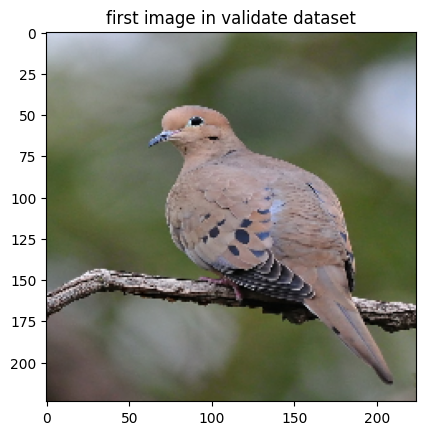

In [13]:
# see the first image, need to enable tf to allow numpy access
# note validation was original set to shuffle and this was driving me nuts since the first image was different every time...
# made validation impossible, fixed this in the load code
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

# first_element = next(iter(default_validate_dataset)) # next element
iterator = iter(default_validate_dataset)  # always the first
first_element = next(iterator)
image_batch = first_element[0]  # size 32 batch, 224, 224, 3
first_image = image_batch[0].numpy().astype(int)  # convert to int so this display correctly
image_labels = first_element[1]  # this should be the labels
print(image_labels[0])
print(np.argmax(image_labels[0]))
plt.imshow(first_image)
plt.title("first image in validate dataset")
plt.show()

In [14]:
# eval by class   
true_labels = np.concatenate([y for x, y in default_validate_dataset], axis=0)  # x is input, y is label one hot encoded per class
print(np.argmax(true_labels[0]))  # first row is item 15
# print(len(true_labels[0]))  # 27 items
true_classes = np.argmax(true_labels, axis=1)  # return the offset that is one hot 
print(true_classes)

0
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6
  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  9  9
  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 11 11 11 11 11
 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 13 13 13 13 13
 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 14 

In [17]:
predictions = model.predict(default_validate_dataset)
predicted_classes = np.argmax(predictions, axis=1)
print(predictions[0])
print(len(predictions[0]))
print(predicted_classes)

Level 1:tensorflow:Creating new FuncGraph for Python function <function Model.make_predict_function.<locals>.predict_function at 0x7f55d69432e0> (key: FunctionCacheKey(function_signature=Tuple(collection_type=<class 'tuple'>, components=(Tuple(collection_type=<class 'tuple'>, components=(Reference(base=IteratorSpec((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 27), dtype=tf.float32, name=None)),), identifier=0),)), Dict(mapping={}))), call_context=FunctionContext(context=EagerContext(parent_graph=None, device_functions=(), colocation_stack=(), in_cross_replica_context=False, variable_policy=None, xla_context_id=0))))
Level 2:tensorflow:Python function signature [args: (<tensorflow.python.data.ops.iterator_ops.OwnedIterator object at 0x7f5708478550>,)] [kwargs: {}]
Level 1:tensorflow:Registering CustomGradient-38257 (<function _graph_mode_decorator.<locals>.internal_grad_fn at 0x7f55d63c6ef0>) in gradient.
Level 1:tensorflow:Registering Cus

2025-04-22 19:24:25.377663: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8900


20/20 [==============================] - 11s 407ms/step
[9.9987185e-01 9.7870980e-05 2.8393285e-07 5.8130453e-08 3.7333857e-06
 2.3146821e-07 7.9569968e-09 1.0440799e-06 6.2151209e-09 3.1291091e-08
 9.8511293e-07 1.8601911e-08 2.2306173e-07 9.8811146e-09 8.3216592e-06
 8.1031789e-07 1.9792390e-07 1.0520304e-07 1.1979857e-06 4.9806654e-06
 1.6835915e-07 5.5398154e-06 5.5995525e-07 2.4150706e-08 4.6130734e-07
 7.9595708e-07 4.5112941e-07]
27
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  1 12  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  6
  4  4  4  4  4  4  4  4  4  4  4  8  4  4  4  4  4  4  4  4  4  4  4  4
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6
  7  7  7 17  7  7  7  7  7  7  7  7  7  7  7

In [18]:
# get the classes, number space text with a line end 
classes_dict = {}
with open('NAbirdsClasses.txt', 'r') as f:
    for line in f:
        line = line.strip()
        if line:  # Ignore empty lines
            parts = line.split(' ', 1)
            if len(parts) == 2 and parts[0].isdigit():
                key = int(parts[0])
                value = parts[1]
                classes_dict[key] = value
print(classes_dict)
class_names = classes_dict.values()
print(class_names)

{0: 'Mourning Dove 529', 1: 'Red-Bellied Woodpecker 553', 2: 'Downy Woodpecker 559', 3: 'Dark-Eyed Junco 746', 4: 'American Robin 753', 5: 'Northern Cardinal Male 772', 6: 'Rose-Breasted Grosbeak Male 773', 7: 'Brown-Headed Cowbird Male 783', 8: 'Baltimore Oriole Male 786', 9: 'Purple Finch Male 788', 10: 'House Finch Male 790', 11: 'American Goldfinch Male 794', 12: 'House Sparrow Male 796', 13: 'Black-Capped Chickadee 812', 14: 'White-Breasted Nuthatch 824', 15: 'Tree Sparrow 894', 16: 'Song Sparrow 902', 17: 'Common Grackle 912', 18: 'Blue Jay 950', 19: 'Northern Cardinal Female Juvenile 979', 20: 'Rose-Breasted Grosbeak Female Juvenile 980', 21: 'Brown-Headed Cowbird Female Juvenile 990', 22: 'Baltimore Oriole Female Juvenile 993', 23: 'Purple Finch Female Juvenile 995', 24: 'House Finch Female Juvenile 997', 25: 'American Goldfinch Female Juvenile 1001', 26: 'House Sparrow Female 1003'}
dict_values(['Mourning Dove 529', 'Red-Bellied Woodpecker 553', 'Downy Woodpecker 559', 'Dark-E

In [19]:
# classification report
report = classification_report(true_classes, predicted_classes, target_names=class_names)
print(report)

                                            precision    recall  f1-score   support

                         Mourning Dove 529       0.96      1.00      0.98        24
                Red-Bellied Woodpecker 553       0.96      0.96      0.96        24
                      Downy Woodpecker 559       0.92      1.00      0.96        24
                       Dark-Eyed Junco 746       0.92      0.96      0.94        24
                        American Robin 753       1.00      0.96      0.98        24
                Northern Cardinal Male 772       0.96      1.00      0.98        24
           Rose-Breasted Grosbeak Male 773       0.96      1.00      0.98        24
             Brown-Headed Cowbird Male 783       0.92      0.96      0.94        24
                 Baltimore Oriole Male 786       0.96      1.00      0.98        22
                     Purple Finch Male 788       1.00      1.00      1.00        21
                      House Finch Male 790       1.00      0.92      0.96  

In [57]:
# confusion matrix 
cm = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[2 1 0 5 2 1 0 0 0 0 3 0 1 0 1 1 0 1 0 1 0 0 1 0 0 1 3]
 [1 1 0 0 1 0 0 2 2 1 2 1 1 2 3 0 2 1 0 0 1 0 0 1 0 2 0]
 [0 1 1 2 1 0 1 0 1 0 1 2 0 2 0 0 2 2 1 0 1 1 2 1 0 0 2]
 [2 0 1 0 2 2 3 0 0 1 0 0 1 0 1 1 1 1 1 1 2 0 1 0 0 3 0]
 [1 1 2 2 1 2 1 1 2 1 1 1 0 0 1 0 0 0 0 2 0 0 1 0 2 1 1]
 [1 2 2 0 0 2 2 2 1 0 1 1 0 0 1 0 0 3 1 1 3 0 1 0 0 0 0]
 [2 3 1 1 2 1 1 1 0 0 1 1 1 0 0 0 1 0 1 0 1 2 0 2 2 0 0]
 [1 2 2 3 0 2 1 1 1 2 0 1 0 0 0 0 0 2 0 0 2 1 2 1 0 0 0]
 [0 1 1 1 0 0 1 2 1 1 0 0 3 1 1 0 1 0 2 2 0 2 1 1 0 0 0]
 [0 0 0 3 0 0 1 0 0 2 1 0 1 1 0 1 1 0 1 1 0 0 1 0 3 1 3]
 [1 0 1 0 1 0 1 0 3 0 0 0 1 1 0 4 1 0 0 1 2 2 1 2 0 0 2]
 [1 1 1 1 0 2 1 0 2 1 0 1 1 1 2 0 0 1 0 2 1 1 1 0 1 1 1]
 [1 1 2 0 2 2 0 2 1 0 0 1 1 0 0 1 1 0 0 2 0 2 0 1 0 1 3]
 [0 0 1 0 0 2 1 0 1 1 2 0 0 1 2 3 0 0 0 1 0 0 1 0 2 1 1]
 [2 0 1 0 3 1 1 2 2 2 1 0 1 0 2 0 1 0 1 0 0 0 1 2 0 0 1]
 [1 0 1 1 1 2 0 1 0 0 0 1 1 0 1 0 1 1 2 0 0 0 1 0 3 2 2]
 [1 0 1 1 1 1 2 2 0 0 0 1 1 2 1 1 1 1 1 2 0 2 1 1 0 0 0]
 [1 0 1 1 1 0

In [20]:
# model summary
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_14 (Rescaling)       (None, 224, 224, 3)  0           ['input_9[0][0]']                
                                                                                                  
 normalization_7 (Normalization  (None, 224, 224, 3)  7          ['rescaling_14[0][0]']           
 )                                                                                                
                                                                                            

In [ ]:
# attempted to reduce code base, but introduced an error 
# def run_model_experiment(lr, epochs, input_size,
#                          train_dataset, validate_dataset, num_classes, 
#                          data_aug_strength = 0.1, l2_reg = 0.001):
#     tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
#     start_time = time.time()
#     start_time_datetime = datetime.datetime.fromtimestamp(start_time)
#     print(f'Start time training and validation: {start_time_datetime.strftime("%Y-%m-%d %H:%M:%S")}')
    
#     inputs = tf.keras.Input(shape=input_size)
#     rescaled_inputs = layers.Rescaling(1./255)(inputs)
#     augmentation_layers = Sequential([
#     #   layers.Resizing(224, 224), # redundant resizing is causing an issue, commented out
#         layers.RandomFlip("horizontal"),
#         layers.RandomRotation(data_aug_strength),
#         layers.RandomTranslation(height_factor=data_aug_strength, width_factor=data_aug_strength),
#     ])
#     augmented_inputs = augmentation_layers(rescaled_inputs)

#     base_model = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=augmented_inputs)
#     base_model.trainable = True

#     # Add custom layers
#     x = base_model.output
#     x = GlobalAveragePooling2D()(x)
#     x = Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
#     predictions = Dense(num_classes, activation='softmax')(x)

    
#     model = Model(inputs=inputs, outputs=predictions)
#     model.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', 
#                   metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])    
    
#     early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
#     reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0000001)
#     history_phase1 = model.fit(train_dataset, epochs=epochs, initial_epoch=0, validation_data=validate_dataset, 
#                                callbacks=[early_stopping, reduce_lr]) 
                    
#     # record training time
#     end_time = time.time()
#     end_time_datetime = datetime.datetime.fromtimestamp(end_time)
#     print(f'End time training and validation: {end_time_datetime.strftime("%Y-%m-%d %H:%M:%S")}')

#     acc = history_phase1.history['accuracy']
#     validate_acc = history_phase1.history['val_accuracy']
#     loss = history_phase1.history['loss']
#     validate_loss = history_phase1.history['val_loss']

#     plot_training_results(acc, validate_acc, loss, validate_loss) 
#     return model